# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
! pip install einops
! git clone https://github.com/ZinebZaad/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import gen_pointcloud, plot_triplets

Cloning into 'exam_2025'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 83 (delta 5), reused 3 (delta 3), pack-reused 74 (from 2)
Receiving objects: 100% (83/83), 2.35 MiB | 27.61 MiB/s, done.
Resolving deltas: 100% (24/24), done.


## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


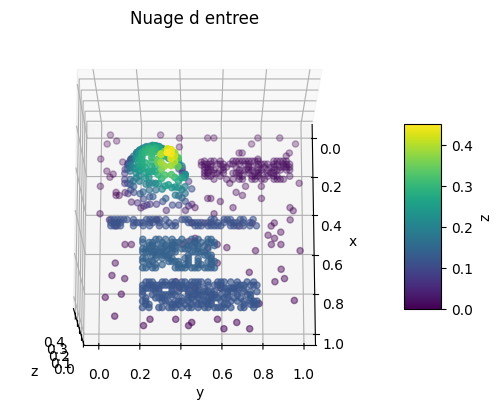

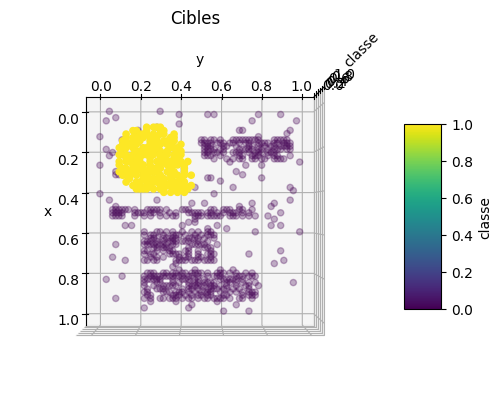

1


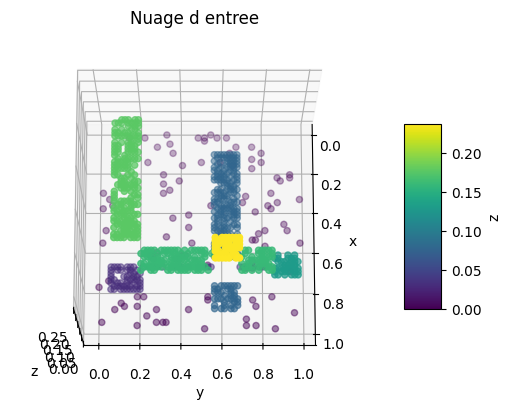

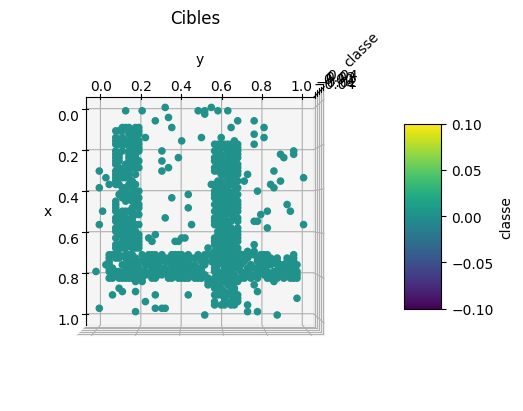

2


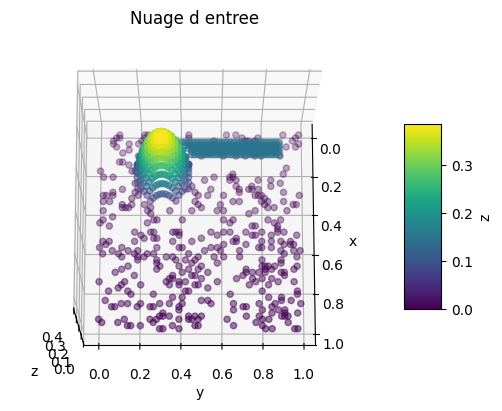

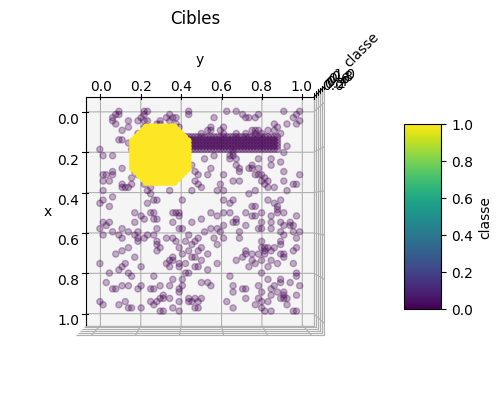

3


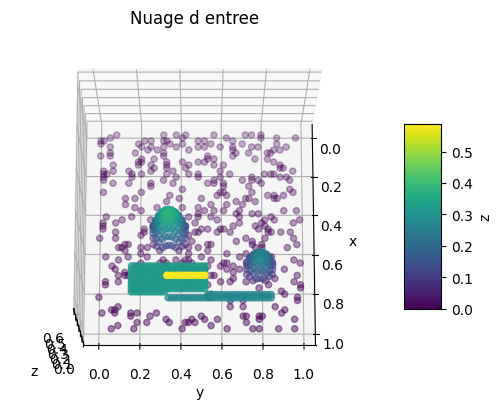

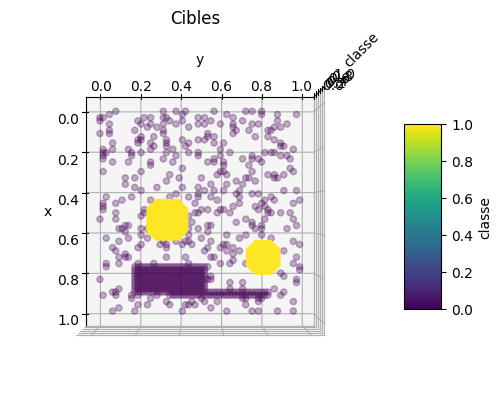

4


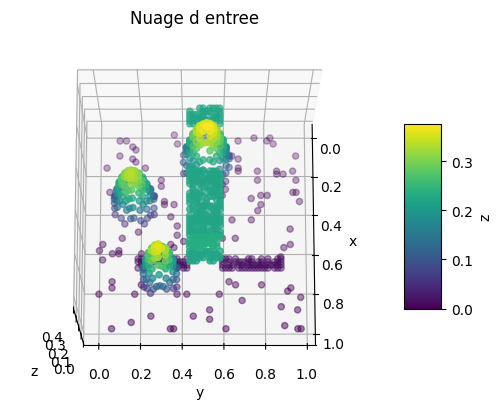

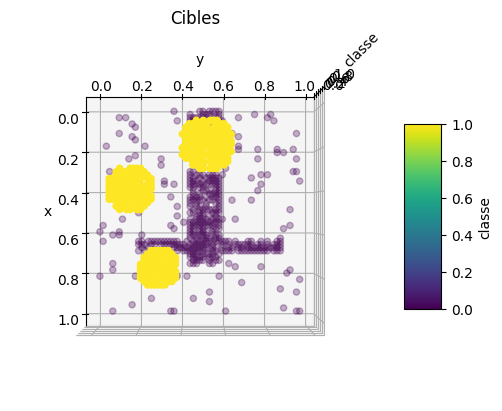

5


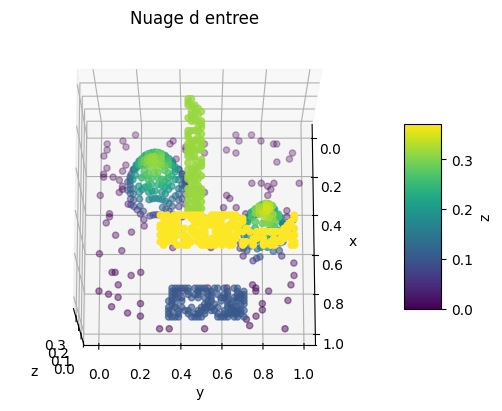

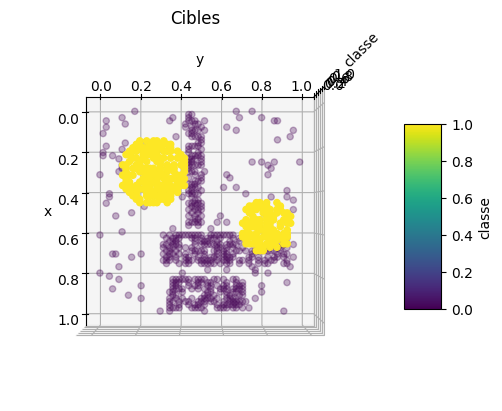

In [3]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation

**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

The dimensions of $\text{input_points}$ represent the structure of 3D point clouds. The first dimension ($\text{batch_size}$) corresponds to the number of point clouds in the batch. The second dimension ($\text{num_points}$) represents the number of points in each cloud, and the third dimension ($\text{num_features}$) corresponds to the features of each point, typically the spatial coordinates $x$, $y$, and $z$. For example, a shape of $(6, 1024, 3)$ indicates 6 point clouds, each containing 1024 points described by 3 features (coordinates).

**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?

ANSWER:

The points in a point cloud are not arranged in any specific order; they are typically distributed randomly across the visible surfaces of objects. In the case of the gen_pointcloud function, points are sampled randomly from surfaces such as building roofs or igloos to simulate realistic data, like LIDAR measurements. This lack of order means that the sequence of points in each cloud is neither structured nor meaningful for the segmentation task. Models like PointNet are designed to be permutation-invariant, ensuring that their processing and performance are not affected by the order of points within a cloud.

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

ANSWER:

Pour traiter le problème de segmentation d'un nuage de points 3D avec un Fully Convolutional Network (FCN) ou un Visual Transformer (ViT), il faudrait adapter les données et la méthode aux caractéristiques spécifiques de ces architectures. Avec un FCN, les nuages de points pourraient être projetés en 2D, par exemple en utilisant une vue de dessus (bird's-eye view) ou des projections multi-vues, ou convertis en une représentation volumétrique comme des voxels. Une fois les données structurées, un FCN peut segmenter les points en classifiant chaque pixel (2D) ou voxel (3D), avec un post-traitement pour attribuer les classes aux points originaux. En revanche, avec un ViT, les nuages de points pourraient être divisés en clusters ou "patches", chacun représenté par des descripteurs géométriques, pour former une séquence d'entrée. Le ViT utiliserait son mécanisme d'attention pour capturer les relations spatiales entre les patches et produire une segmentation précise. Le choix entre ces deux approches dépend des contraintes : un FCN est plus adapté pour des données structurées comme des voxels ou des projections, tandis qu’un ViT est mieux adapté aux données non structurées mais nécessite plus de ressources pour traiter de longues séquences ou capturer la géométrie complexe.

## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [4]:
from utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)

**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

ANSWER:

The output of the PointNet model, represented by the first tensor of the tuple returned by the forward function, has dimensions $(\text{batch_size}, \text{num_points}, m)$, where $\text{batch_size}$ is the number of point clouds in the batch, $\text{num_points}$ is the number of points per cloud, and $m$ is the number of classes (e.g., $m=2$ for binary segmentation). Each entry represents the predicted probabilities for each class, computed via a softmax activation. According to the paper PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation (Qi et al., 2017), PointNet respects permutation invariance of points by processing each point independently using Multilayer Perceptrons (MLPs) and aggregating global features through a symmetric function (e.g., max pooling). This ensures that permutations in the input points do not affect the output predictions. The following code verifies this property by permuting the input points with torch.randperm and comparing the outputs:

In [11]:
import torch

# Generate random input points
input_points, _, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()

# Get the original output
output_original, _, _ = pointnet(input_points)

# Permute the points in the input
idx = torch.randperm(input_points.shape[1])
input_points_permuted = input_points[:, idx, :]

# Get the output with permuted points
output_permuted, _, _ = pointnet(input_points_permuted)

# Compare the outputs
diff = torch.abs(output_original - output_permuted)
print(diff.max())  # Should be close to 0

tensor(11.3983, device='cuda:0', grad_fn=<MaxBackward1>)


**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

ANSWER:

Dans PointNet (Qi et al., 2017), en dehors des deux opérations principales de transformation (input transform et feature transform), la segmentation d’un nuage de points s’effectue via une suite de MLP (Multilayer Perceptrons) appliqués point par point, puis via une agrégation globale invariante à l’ordre des points (typiquement un max-pooling). Une fois la représentation globale obtenue, on la concatène aux caractéristiques locales de chaque point, et un second MLP, appliqué de manière partagée (c’est-à-dire que le même MLP est utilisé pour chaque point), produit les scores de segmentation. Le fait que les MLP “shared” ne dépendent pas de la position d’un point dans la liste et que le max-pooling soit une opération symétrique (son résultat ne change pas quand on permute l’ordre des points) garantit l’invariance du réseau par permutation. Le terme “shared” renvoie à l’utilisation des mêmes poids pour chaque point, ce qui assure un traitement identique et indépendant de la position du point dans le nuage, tandis que la symétrie de l’agrégation (max-pooling) permet au réseau de produire une représentation globale identique, quel que soit l’ordre dans lequel on présente les points.










<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [ ]:
optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))

# manually set alpha weights
alpha = np.array([0.2, 0.8])
gamma = 1
loss_fn = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).cuda()

# exemple d'utilisation de PointNetSegLoss:
# La transposition permet de repasser la dimension relative
# aux probabilités en dernier, comme avec torch.nn.CrossEntropyLoss
proba_pred_list = outputs.transpose(1,2)
loss_fn(proba_pred_list, target_list)

In [ ]:
batch_size = 64
n_epochs = 200
n_batch_per_epoch = 10


for epoch in range(1, n_epochs):
  print('epoch : ', epoch)
  for batch in range(1,n_batch_per_epoch):
    ...

In [ ]:
input_points, target_list , target_points = gen_pointcloud(6)

# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet2.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()

# Accuracy:
...
# Tracé

for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  plot_triplets(...,
                title='Predictions',
                cbar_label='classe')
